In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/BigDataHub/Differentiable_Render/

/content/drive/MyDrive/BigDataHub/Differentiable_Render


In [ ]:
try:
  import datatools_bdh
except ModuleNotFoundError:
  !pip install git+https://github.com/sfu-bigdata/datatools-bdh.git
  import datatools_bdh
from datatools_bdh.ipython import *

  Cloning https://github.com/sfu-bigdata/datatools-bdh.git to /tmp/pip-req-build-t7geafby
  Running command git clone -q https://github.com/sfu-bigdata/datatools-bdh.git /tmp/pip-req-build-t7geafby
  Created wheel for datatools-bdh: filename=datatools_bdh-0.1-py3-none-any.whl size=33526 sha256=7b4b5a6ffc0b07aacce1290bef061104e93d56ac0d2a5b0e91aa6cb1d7361b37
  Stored in directory: /tmp/pip-ephem-wheel-cache-r_hafj_6/wheels/dd/f7/e6/04bb4fb69b7d39aa1c649649a211bfdff04186aaa3defc6d96
Successfully built datatools-bdh


In [ ]:
import pandas as pd
from datatools_bdh import _get_resource_path
from IPython.display import Markdown
import matplotlib.pyplot as plt
import seaborn as sns

# !wget https://raw.githubusercontent.com/sfu-bigdata/range-driver/public/range_driver/dict_utils.py
from dict_utils import *

base_dir = '/content/drive/MyDrive/BigDataHub/Differentiable_Render/conf/'
ymal_path = "training_config.yml"
conf = yload(open(base_dir + ymal_path))

In [ ]:
plt.style.use(_get_resource_path('report.mplstyle'))
def displaymd(mdstr):
    display(Markdown(mdstr))

In [ ]:
# retrive the training output files from config 

data_path = conf.train.output_result_dir

train_name = conf.analysis.train_loss_profile
val_name = conf.analysis.val_loss_profile
train_net_out_name = conf.analysis.train_output_profile
val_net_out_name = conf.analysis.val_output_profile

## load the loss and output profiles

In [ ]:
#data_path = "../data"

suffix = ""
#val_loss = pd.read_csv(f"{data_path}/val_loss_detail_pdepoch50{suffix}.csv")
val_loss = pd.read_csv(f"{data_path}{val_name}")
val_loss.set_index(['epoch','batch_id','index'])
# there are some irregular rows in this val loss .csv, we split them out below
total_rows = val_loss.isna().any(axis=1)
if any(total_rows):
    val_loss_totals = val_loss[total_rows]
    val_loss = val_loss[~total_rows]
if  val_loss_totals.iloc[0,0][0] == '[':
    val_loss_totals.iloc[:,-3:] = val_loss_totals['epoch'].str[1:-1].str.split(expand=True)
    val_loss_totals.loc[:,'epoch'] = val_loss.loc[val_loss_totals.index-1, 'epoch']

#train_loss = pd.read_csv(f"{data_path}/train_loss_detail_pdepoch50{suffix}.csv")
train_loss = pd.read_csv(f"{data_path}/{train_name}")

In [ ]:
val_net_output = pd.read_csv(f"{data_path}/{val_net_out_name}")
train_net_output = pd.read_csv(f"{data_path}/{train_net_out_name}")

num_index = train_net_output['index'].unique().shape[0] # batch_size
train_net_output['ex_id'] = train_net_output['batch_id']*num_index+train_net_output['index']
val_net_output['ex_id'] = val_net_output['batch_id']*num_index+val_net_output['index']


In [ ]:
train_net_output.shape
val_net_output.shape

(5000, 14)

In [ ]:
import numpy as np
def col_to_int(col):
    return lambda x: pd.to_numeric(x[col]).astype(int)

train_loss = train_loss.assign(epoch=col_to_int('epoch'),
                  batch_id=col_to_int('batch_id'),
                  index=col_to_int('index'))
val_loss = val_loss.assign(epoch=col_to_int('epoch'),
                  batch_id=col_to_int('batch_id'),
                  index=col_to_int('index'))

In [ ]:
train_loss.shape[0]/725
val_loss.shape[0]/250

20.0

In [ ]:
# calculate the index
num_index = train_loss['index'].unique().shape[0] # batch_size
train_loss['ex_id'] = train_loss['batch_id']*num_index+train_loss['index']
val_loss['ex_id'] = val_loss['batch_id']*num_index+val_loss['index']

In [ ]:
# dataset size
train_dsize = train_loss[train_loss['epoch'] ==0 ].shape[0]
val_dsize = val_loss[val_loss['epoch'] ==0 ].shape[0]

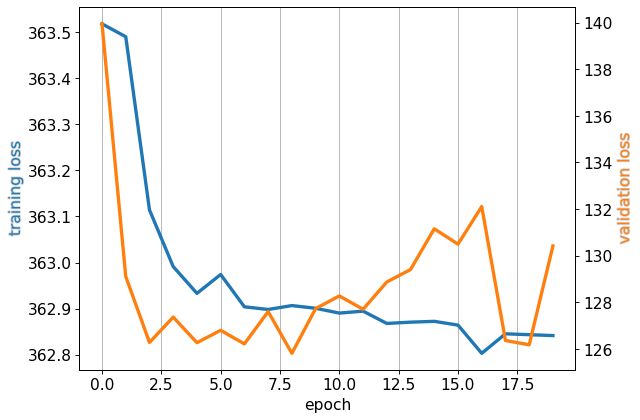

In [ ]:
import matplotlib.patheffects as pe
color_cycle_plt = plt.rcParams['axes.prop_cycle'].by_key()['color']
peff = [pe.withStroke(linewidth=1.5, foreground="lightgray")]

#ax = plt.su(figsize=(16,12))
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.gca()
train_loss.groupby('epoch').mean().loc[:,"t1":].sum(axis=1).plot(ax=ax)
# twin object for two different y-axis on the sample plot
ax.set_ylabel("training loss",
               color=color_cycle_plt[0],
               fontsize=14, 
               path_effects=peff)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
#ax2.plot(gapminder_us.year, gapminder_us["gdpPercap"],color="blue",marker="o")
ax2.set_ylabel("validation loss",
               color=color_cycle_plt[1],
               fontsize=14, 
               path_effects=peff)
val_loss.groupby('epoch').mean().loc[:,"t1":].sum(axis=1).plot(c=color_cycle_plt[1], ax=ax2)
ax.xaxis.grid(True)
ax2.set_axisbelow(True)

# Distribution of loss term slope across training and validation examples
For each training or validation example, the three loss terms t1, t2, t3 are each fitted to a linear model w.r.t. training time given by the number of epochs.
A negative slope indicates that the respective loss term for an example improves (i.e. gets smaller with increasing epochs).

We are sorting the slopes across all examples to get an idea of their distribution around the average slope across all examples (average slope of total loss),
which is indicated by a gray horizontal line in each plot.


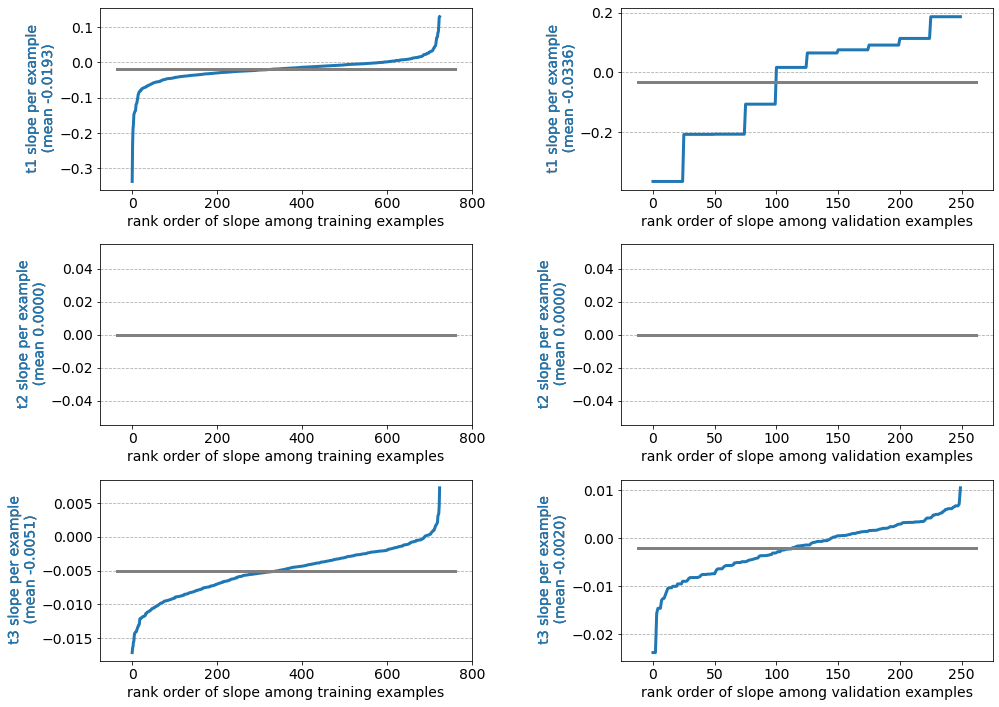

In [ ]:


from scipy import stats

plt.rc('text', usetex=False)
peff = [pe.withStroke(linewidth=.2, foreground="black")]

def plot_target_field(target_field, sample_data, **kwargs):
    lmdf = (sample_data
            .groupby('ex_id')
            .apply(lambda gn: stats.linregress(gn['epoch'], gn[target_field]))
            .apply(pd.Series)
           )
    lmdf.columns = "slope intercept r_value p_value std_err".split()
    mean_slope = lmdf['slope'].mean()
    plt.plot(lmdf['slope'].sort_values().values, linewidth=3, **kwargs)
    plt.plot(plt.gca().get_xlim(),
             [mean_slope]*2,
             color='gray',
             **kwargs)
    plt.ylabel(f'{target_field} slope per example\n(mean {mean_slope:.4f})',
               color=color_cycle_plt[0],
               fontsize=14, 
               path_effects=peff)
    plt.xlabel('rank')
    plt.gca().yaxis.grid(True, linestyle='dashed')
    return lmdf

#plt.figure(figsize=(6,4))
fig, axs = plt.subplots(3,2, figsize=(16, 12))
displaymd("""# Distribution of loss term slope across training and validation examples
For each training or validation example, the three loss terms t1, t2, t3 are each fitted to a linear model w.r.t. training time given by the number of epochs.
A negative slope indicates that the respective loss term for an example improves (i.e. gets smaller with increasing epochs).

We are sorting the slopes across all examples to get an idea of their distribution around the average slope across all examples (average slope of total loss),
which is indicated by a gray horizontal line in each plot.
""")
plt.subplots_adjust(wspace=.4, hspace=.3)
vlmdfs = None
tlmdfs = None
for tid, term in enumerate(['t1', 't2', 't3']):
    #sample_data = choose_N_examples(val_loss, N=10, field='ex_id')
    ax=axs[tid][1] # right axis in row tid
    plt.sca(ax)
    vlmdf = plot_target_field(term, val_loss)
    vlmdf['term'] = term
    vlmdfs = pd.concat([vlmdfs, vlmdf])
    plt.xlabel('rank order of slope among validation examples')
    sample_data = (train_loss.groupby('ex_id')
                                  .sample(3)
                                  .reset_index(drop=False))
    ax=axs[tid][0] # left axis in row tid
    plt.sca(ax)
    tlmdf = plot_target_field(term, train_loss)
    tlmdf['term'] = term
    tlmdfs = pd.concat([tlmdfs, tlmdf])
    plt.xlabel('rank order of slope among training examples');


In [ ]:
def add_ex_info(lmdfs, df):
    if 'batch_id' not in lmdfs:
        ex_ids = df[['batch_id','index','ex_id']].drop_duplicates()
        #display(ex_ids)
        lmdfs = lmdfs.join(ex_ids)#.sort_values(by='slope', ascending=False)
        return lmdfs.set_index(['batch_id','index']).sort_index()
    return lmdfs
vlmdfs = add_ex_info(vlmdfs, val_loss)
tlmdfs = add_ex_info(tlmdfs, train_loss)

#.plot(style='.', alpha=.5)
#sns.heatmap(data=vlmdfs, x='batch_id', y='index', c='slope')

In [ ]:
def floor_factor(value, factor):
    return np.floor(value/factor)*factor

def ceil_factor(value, factor):
    return np.ceil(value/factor)*factor

def grid_ticks(ser, step=.05):
    return np.arange(floor_factor(ser.min(), step),
                     ceil_factor(ser.max(), step),
                     step)

do_show_scatterslopes = False
if do_show_scatterslopes:
    tlmdfs['slope'].plot(style='.', alpha=.1)
    # make a grid of .05 spaced ticks
    plt.gca().set_yticks(grid_ticks(tlmdfs['slope']))
    plt.grid('minor')

# Comparing loss slope distribution between training and validation

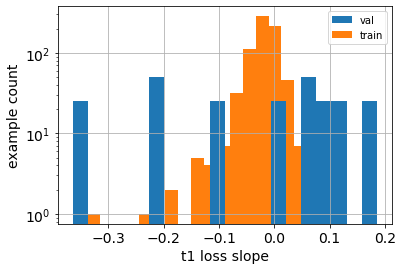

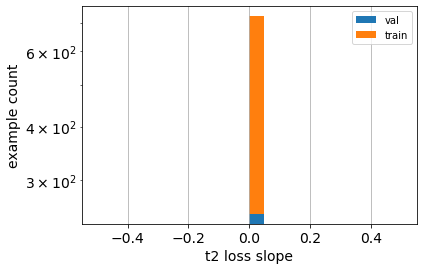

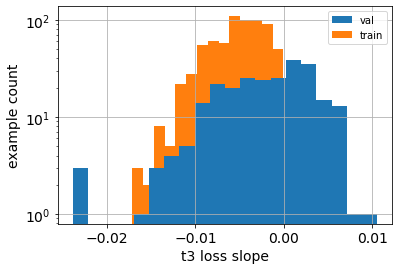

In [ ]:
displaymd("# Comparing loss slope distribution between training and validation")
hist_ps = dict(bins=20, log=True)
for field in ['t1', 't2', 't3']:
    (vlmdfs[(vlmdfs['term']==field).values]
      .sort_index()['slope']
      .hist(**hist_ps)
    )
    (tlmdfs[(tlmdfs['term']==field).values]
      .sort_index()['slope']
      .hist(**hist_ps, zorder=0)
    )
    plt.yscale('log')
    plt.legend(['val', 'train'])
    plt.xlabel(f"{field} loss slope")
    plt.ylabel("example count");
    plt.show()
    #sns.heatmap(data=vlmdfs, x='batch_id', y='index', c='slope')

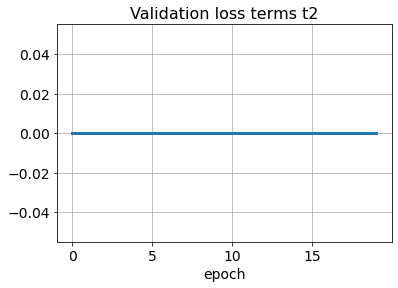

In [ ]:
import matplotlib.pyplot as plt
target_term = "t2"
if False:
    trainval = "Training"
    dat = train_loss
else:
    trainval = "Validation"
    dat = val_loss
# taking the mean across: batch_id, index
(dat.groupby('epoch').mean().loc[:,target_term]
 #.sum(axis=1)
 .plot())
plt.title(f"{trainval} loss terms {target_term}")
plt.grid(True)

In [ ]:
#vlmdfs.sort_values('slope', ascending=False).index[:10]

# (val_loss
#  .set_index(['batch_id','index'])
# .join(vlmdfs.sort_values('slope', ascending=False).iloc[:10]))

#tlmdfs.sort_values('slope', ascending=False).iloc[:10]


In [ ]:
## read the image from drive (here I use sythetic image from  Boeing)
## option:  appy segmentation mask on image
import cv2
import os
import numpy as np

# acquire target img
def gen_target(synthetic_base_dir, img_name, seg_name):
    #read RGB image
    img_p = os.path.join(synthetic_base_dir, 'render_imgs', img_name)
    seg_p = os.path.join(synthetic_base_dir, 'seg_imgs', seg_name)

    target_img = cv2.imread(img_p)
    # print(target_img)

    #read segmentation img
    seg_img = cv2.imread(seg_p)

    # print(seg_img.shape)
    # print(np.unique(seg_img))
    # print(target_img.shape)

    ## apply segmentation mask on image (depends on your needs)
    target_img = target_img * (seg_img/255.0)
    #plt.imshow(seg_img.astype(np.float))
    #plt.imshow(target_img/255.0)
    #plt.show()
    
    return target_img

In [ ]:
def visualize_picked_images(ex_index_list, mode):
   
   seq_file = 'metadata_train_sequence.txt' if mode=="Training" else ('metadata_val_sequence.txt' if mode =="Validation" else 'metadata_test_sequence.txt')
   print("\n==================================")
   print(f"mode: {mode}  seq_file:{seq_file}  ex_index_list: {ex_index_list} " )

   top_sweeps = []
   for ex_id in ex_index_list:
     # retrive sweep from meta file
     print(f"\n----------------------- sample index: {ex_id} ---------------------------")
     visual_sweep(seq_file, ex_id)
     #get network output of last epoch
     dis_of_lastepoch_val = val_net_output.iloc[-val_dsize:,:]
     dis_of_lastepoch_train = train_net_output.iloc[-train_dsize:,:]
     #print distance of souce images in sweep
     #print("=====", distance_of_lastepoch[distance_of_lastepoch['ex_id'] == ex_id].loc[:,'d0':'d8'].to_numpy())
     if mode == "Validation":
       d = dis_of_lastepoch_val[dis_of_lastepoch_val['ex_id'] == ex_id].loc[:,'d0':'d8'].to_numpy()[0].tolist()
     elif mode == "Training":
       d = dis_of_lastepoch_train[dis_of_lastepoch_train['ex_id'] == ex_id].loc[:,'d0':'d8'].to_numpy()[0].tolist()
    
     display_d = list(map(lambda x:round(x, 4), d))
     print(f"distance: {display_d}")
     print(f"deviation strategy: {strategy_pose[ex_id%25]}" )
     #top_sweeps.append(sweep_names)
  
   return top_sweeps



In [ ]:
def visual_sweep(seq_file, ex_id):
    df_st = pd.read_csv(dataset_dir + seq_file, header=None)
    df_st[21] = None
    df_st.loc[:,12:21] = df_st.loc[:,11:20].values
    df_st.loc[:,10:11] = df_st.loc[:,10].str.split(expand=True).values
    
    #get the sample
    print("=================", ex_id, dataset_dir + seq_file)
    print(df_st.shape)

    sample_info = df_st.iloc[ex_id,:].to_numpy()
    #print("sample info :", sample_info)
    
    tg_img_name = sample_info[0]
    sweep_names = sample_info[1:11]
    #print(f"sweep name: {sweep_names}")

    s_img_p = dataset_dir + "train_seq/"
    t_base_dir = dataset_dir + "Blender_images"
    
    #get target image
    target_img = gen_target(t_base_dir, tg_img_name, tg_img_name)
    target_img = cv2.resize(target_img,(400,300))
    
    plt.imshow(target_img[:,:,::-1]/255.0)
    plt.show()
    plt.figure(figsize=(25,15))
    for idx, s_img_name in enumerate(sweep_names):
      # get source image:
      #print(s_img_p + s_img_name)
      s_img = cv2.imread(s_img_p + s_img_name)
      # generate difference img between t and s
      diff_img = np.abs(target_img - s_img)/255.0
      
      # display images sweep   
      plt.subplot(1,10,idx+1)
      plt.axis('off')
      plt.imshow(diff_img)
    plt.show()




    


In [ ]:
def plot_lines(gdf, groupvar='epoch', fields=['t1','t2'], 
               c=None, nsteps=100, 
               group_agg='mean', 
               cmap='turbo', decorate=True, 
               kind='scatter',
               **kwargs):
    if not groupvar is None:
        gdf = gdf.groupby(groupvar).mean()
    gdf = gdf.reindex(np.arange(0,gdf.index.max(),1/nsteps)).interpolate('linear')
    if c is None:
        c = gdf.index
    data_args = dict(data=gdf, x=fields[0], y=fields[1])
    if kind == 'scatter':
        plt.scatter(
            **data_args,
            c=c, s=3, cmap=cmap, 
            **kwargs)
    elif kind == 'line':
        sns.lineplot(
            data=gdf, x=groupvar, y=fields[0],
            #**data_args,
#            c=c, s=3, cmap=cmap, 
            **kwargs)
    else:
        sns.kdeplot(
            **data_args,
            **kwargs)
    if decorate:
        plt.xlabel(fields[0])
        plt.ylabel(fields[1])
        cbar = plt.colorbar()
        if not groupvar is None:
            cbar.set_label(groupvar)
            cbar.set_alpha(1)
            cbar.draw_all()
        plt.grid()


plt.figure(figsize=(6,5))

def plot_ex_loss_term(mode, sel_ex, loss_df, fields=['t2','t3'], ):
    sel_ex_ids = sel_ex['ex_id']
    #visualize_picked_images(sel_ex_ids)
    #print("sel_ex =======, ")
    #print( sel_ex['ex_id'].to_numpy())

    val_loss_sample = loss_df.set_index('ex_id').loc[sel_ex_ids]
    scatter_ps = dict(kind='scatter')
    line_ps = dict(kind='line', decorate=False, alpha=.6)
    kde_ps = dict(kind='kde', fill=True, cmap='mako', decorate=False)
    plot_ps = line_ps
    #k, gdf = 0, val_loss_sample
    display(sel_ex[['slope','term','ex_id']])
    for k, (gn, gdf) in enumerate(val_loss_sample.groupby('ex_id')):
        if not 'decorate' in plot_ps:
            add_arg = dict(decorate=(k==0))
        else:
            add_arg = {}
        plot_lines(gdf,
                   fields=fields,
                   **plot_ps,
                   **add_arg,
                  )
    plt.grid(True)
    plt.show()

    #visualization
    visualize_picked_images(sel_ex['ex_id'].to_numpy(), mode)

def show_top_bottom(field, lmdfs, loss_df, mode, ntop=10 ):
    fields = [field, 't3']
    displaymd(f"### Top {ntop} examples for {field}")
    #ex_ids = val_loss[['batch_id','index','ex_id']].drop_duplicates()
    slmdfs = lmdfs.loc[lmdfs['term']==field].sort_values(by='slope', ascending=True)
    sel_ex = slmdfs.iloc[:ntop]
    plot_ex_loss_term(mode, sel_ex, loss_df=loss_df,  fields=fields)
    plt.show()

    displaymd(f"### Bottom {ntop} examples for {field}")
    sel_ex = slmdfs.iloc[-ntop:]
    plot_ex_loss_term(mode, sel_ex, loss_df=loss_df, fields=fields, )
    plt.show()




<Figure size 432x360 with 0 Axes>

## Top and bottom perfomance of cases analysis

In [ ]:
#----------------------
dataset_dir = conf.dataset.dataset_dir

displaymd("# Loss change per example across epochs")

# for mode, (lmdfs, loss_df) in {'Training': (tlmdfs, train_loss),
#                                'Validation': (vlmdfs, val_loss)}.items():

for mode, (lmdfs, loss_df) in {'Validation': (vlmdfs, val_loss)}.items():

    displaymd(f"## {mode} performance across epochs")
    show_top_bottom('t1', lmdfs, loss_df, mode)
    show_top_bottom('t2', lmdfs, loss_df, mode)
    show_top_bottom('t3', lmdfs, loss_df, mode)

Output hidden; open in https://colab.research.google.com to view.

## HTML image embedded in colab

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

In [ ]:
from datatools_bdh.data_uri import bytes_to_uri
def embeding_html_imgs(img_names):
  # convert image name list to Dataframe HTML
  #  img_name:  list of image names   e.g.  img_names = ["image_a.jpg","image_b.jpg"]
  # return value: dataframe, which can display image list as HTML in jupyternotbook
    num = len(img_names)
    img_names = np.array(img_names).reshape(-1,len(img_names))
    df = pd.DataFrame(img_names)

    
    # could import this from datatools_bdh.all
    def html_img(ipath, widthpx=120):
        return f'<img width="{widthpx}px" src="{ipath}"/>'

    def make_file_uri(fname):
        try:
          return bytes_to_uri(open(fname,'rb').read())
        except:
          print(f"{fname} not found")
          return ";"

    #df = df.applymap(lambda c: f"<b>{c}</b>")
    df = df.applymap(lambda c: html_img(make_file_uri(c),widthpx=100))
    df.columns = ['']*df.shape[1]
    df.index.name = None
    df.index = ['']*df.shape[0]
    display(HTML(df.to_html(escape=False)))
    return df

img_names = ["image_a.jpg","image_b.jpg"]
df = embeding_html_imgs(img_names)
#HTML(df.to_html(escape=False))